### Function Approximation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tempfile
import base64
import pprint
import random
import json
import sys
import gym
import io

from gym import wrappers
from collections import deque
from subprocess import check_output
from IPython.display import HTML

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def action_selection(state, model, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    values = model.predict(state.reshape(1, 4))[0]
    if np.random.random() < epsilon:
        action = np.random.randint(len(values))
    else:
        action = np.argmax(values)
    return action, epsilon

In [13]:
def neuro_q_learning(env, gamma = 0.99):
    nS = env.observation_space.shape[0]
    nA = env.env.action_space.n
    
    memory_bank = deque()
    memory_bank_size = 100000
    
    model = Sequential()
    model.add(Dense(128, input_dim=nS, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nA, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    n_episodes = 50000
    batch_size = 256
    training_frequency = 20
    
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, model, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            nstate, reward, done, info = env.step(action)
            memory_bank.append((state, action, reward, nstate, done))
            if len(memory_bank) > memory_bank_size:
                memory_bank.popleft()
                
            state = nstate

        if episode % training_frequency == 0 and len(memory_bank) == memory_bank_size:
            minibatch = np.array(random.sample(memory_bank, batch_size))

            state_batch = np.array(minibatch[:,0].tolist())
            action_batch = np.array(minibatch[:,1].tolist())
            rewards_batch = np.array(minibatch[:,2].tolist())
            state_prime_batch = np.array(minibatch[:,3].tolist())
            is_terminal_batch = np.array(minibatch[:,4].tolist())

            state_value_batch = model.predict(state_batch)
            next_state_value_batch = model.predict(state_prime_batch)

            for i in range(len(minibatch)):
                if is_terminal_batch[i]:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i]
                else:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i] + gamma * np.max(next_state_value_batch[i])

            model.train_on_batch(state_batch, state_value_batch)

    return model, (epsilons, states, actions)

In [14]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

model, stats = neuro_q_learning(env)

[2017-04-23 04:50:24,460] Making new env: CartPole-v0
[2017-04-23 04:50:24,623] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000000.mp4
[2017-04-23 04:50:25,119] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000001.mp4
[2017-04-23 04:50:26,040] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000008.mp4
[2017-04-23 04:50:26,902] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000027.mp4
[2017-04-23 04:50:27,893] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000064.mp4
[2017-04-23 04:50:29,142] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000125.mp4
[2017-04-23 04:50:30,894] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2.6032.video000216.mp4
[2017-04-23 04:50:33,072] Starting new video recorder writing to /tmp/tmpj5o4dww6/openaigym.video.2

In [21]:
videos = np.array(env.videos)
n_videos = 4

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [6]:
epsilons, states, actions = stats

In [15]:
env.close()

[2017-04-23 05:32:09,378] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpj5o4dww6')


In [16]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-23 05:32:09,452] [CartPole-v0] Uploading 50000 episodes of training data
[2017-04-23 05:32:12,052] [CartPole-v0] Uploading videos of 59 training episodes (342053 bytes)
[2017-04-23 05:32:12,562] [CartPole-v0] Creating evaluation object from /tmp/tmpj5o4dww6 with learning curve and training video
[2017-04-23 05:32:12,871] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_y8lckePTjSFZ4nm8FeDsQ

****************************************************


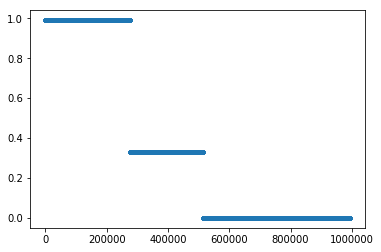

In [9]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

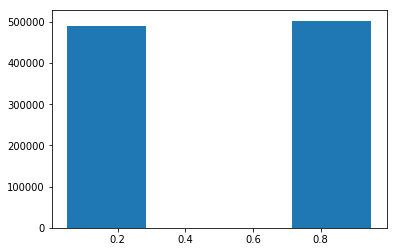

In [10]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Test

In [22]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

for episode in range(100):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(model.predict(state.reshape(1, 4))[0])
        nstate, reward, done, info = env.step(action)
        state = nstate

[2017-04-23 05:40:40,477] Making new env: CartPole-v0
[2017-04-23 05:40:40,484] Starting new video recorder writing to /tmp/tmpa3exuz6m/openaigym.video.5.6032.video000000.mp4
[2017-04-23 05:40:42,596] Starting new video recorder writing to /tmp/tmpa3exuz6m/openaigym.video.5.6032.video000001.mp4
[2017-04-23 05:40:45,105] Starting new video recorder writing to /tmp/tmpa3exuz6m/openaigym.video.5.6032.video000008.mp4
[2017-04-23 05:40:48,605] Starting new video recorder writing to /tmp/tmpa3exuz6m/openaigym.video.5.6032.video000027.mp4
[2017-04-23 05:40:53,552] Starting new video recorder writing to /tmp/tmpa3exuz6m/openaigym.video.5.6032.video000064.mp4
[2017-04-23 05:40:58,377] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpa3exuz6m')


In [24]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [25]:
env.close()

In [26]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-23 05:41:15,954] [CartPole-v0] Uploading 100 episodes of training data
[2017-04-23 05:41:16,508] [CartPole-v0] Uploading videos of 5 training episodes (49985 bytes)
[2017-04-23 05:41:16,949] [CartPole-v0] Creating evaluation object from /tmp/tmpa3exuz6m with learning curve and training video
[2017-04-23 05:41:17,687] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_4NgT7xl3QjyUafkrEqBuEg

****************************************************
